# 1. Setup

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import fitbit
import gather_keys_oauth2 as Oauth2
import pandas as pd 
import datetime
import numpy as np
from datetime import timedelta

In [ ]:
## CLIENT_ID='22BN2X'
CLIENT_SECRET='d65e1e17d06b5488dc992463341b2d59'

server=Oauth2.OAuth2Server(CLIENT_ID, CLIENT_SECRET)
server.browser_authorize()
ACCESS_TOKEN=str(server.fitbit.client.session.token['access_token'])
REFRESH_TOKEN=str(server.fitbit.client.session.token['refresh_token'])
auth2_client=fitbit.Fitbit(CLIENT_ID,CLIENT_SECRET,oauth2=True,access_token=ACCESS_TOKEN,refresh_token=REFRESH_TOKEN)

# 2. Data Collection

In [6]:
DATE_FORMAT = '%Y-%m-%d'
databaseFilename = 'data/database_main.xls'

def connectAndLoadDb():
    print("Connecting database...")
    database = pd.read_excel(databaseFilename)
    print("Database connected!")
    return database;

def getLastEntryDate(database):
    lastDateEntry = database.iloc[-1]['Date']
    lastDateEntry = datetime.datetime.strptime(lastDateEntry, DATE_FORMAT)    
    return lastDateEntry

def addEntriesInDB(dictionary, database):
    #print(dictionary)
    database = database.append(dictionary, ignore_index=True)
    return addEntriesInDB;

def writeDbToExcelFile(database):
    print('Writing database to filename: '+ databaseFilename)
    writer = pd.ExcelWriter(databaseFilename)
    database.to_excel(writer, 'main')
    writer.save()
    print('Database updated with new entries!!')
    
def prettyPrintDate(date):
    return date.strftime(DATE_FORMAT);

In [7]:
def safeGet(obj, key, defaultVal = np.nan):
    return obj.get(key, defaultVal)  

def percent(val):
    return np.ceil(val*100)

def filterArrObj(arrList, keyName, keyValue):
    for arrItem in arrList:
        if arrItem.get(keyName) == keyValue:
            return arrItem
    return {} 

def mergeDicts(dicts):
    super_dict = {}
    for singleDict in dicts:
        for k, v in singleDict.items(): 
            super_dict[k] = v
    return super_dict

    
def getActivities(date):
    activitiyResponse = auth2_client.activities(date=date)
    
    activitySummary = activitiyResponse['summary'];
    activityData = {
        'Calories Burned':safeGet(activitySummary,'caloriesOut'),
        'Calories BMR': safeGet(activitySummary,'caloriesBMR'),
        'Resting Heart Rate':safeGet(activitySummary,'restingHeartRate'),
        'Steps':safeGet(activitySummary,'steps'),
        'Distance (Km)':filterArrObj(activitySummary.get('distances', []), 'activity', 'total').get('distance', np.nan),
        'Elevation (Ft)':activitySummary['elevation'],
        'Floors':activitySummary['floors'],
        'Minutes Sedentary':activitySummary['sedentaryMinutes'],
        'Minutes Lightly Active':activitySummary['lightlyActiveMinutes'],
        'Minutes Fairly Active':activitySummary['fairlyActiveMinutes'],
        'Minutes Very Active':activitySummary['veryActiveMinutes'],
        'Activity Calories': activitySummary['activityCalories'],
        'Active Score': activitySummary['activeScore'],
        'Cardio minutes': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Cardio').get('minutes', np.nan),
        'Cardio calories': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Cardio').get('caloriesOut', np.nan),
        'Fat Burn minutes': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Fat Burn').get('minutes', np.nan),
        'Fat Burn calories': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Fat Burn').get('caloriesOut', np.nan),
        'Peak minutes': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Peak').get('minutes', np.nan),
        'Peak calories': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Peak').get('caloriesOut', np.nan),
        'Normal Cardio minutes': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Out of Range').get('minutes', np.nan),
        'Normal Cardio calories': filterArrObj(activitySummary.get('heartRateZones', []), 'name', 'Out of Range').get('caloriesOut', np.nan),
    }
    
    return activityData

In [60]:
#Need this seeparately because version 1 doesn't give sleep breakdown
auth2_client_new = fitbit.Fitbit(CLIENT_ID, CLIENT_SECRET, oauth2=True, access_token=ACCESS_TOKEN, refresh_token=REFRESH_TOKEN, system='en_GB')
auth2_client_new.API_VERSION = 1.2

In [62]:
def getSleep(date):
    sleepResponse = auth2_client_new.sleep(date=date)
    
    sleepData = {}
    for sleepLog in sleepResponse.get('sleep', []):
        if sleepLog.get('isMainSleep'):
            sleepLevelsSummary = sleepLog.get('levels', {}).get('summary', {})
            
            sleepData['Sleep Efficiency'] = safeGet(sleepLog, 'efficiency')
            sleepData['Minutes Asleep'] = safeGet(sleepLog, 'minutesAsleep')
            sleepData['Minutes to fall asleep'] = safeGet(sleepLog, 'minutesToFallAsleep')
            sleepData['Sleep Start time'] = safeGet(sleepLog, 'startTime')
            sleepData['Sleep End time'] = safeGet(sleepLog, 'endTime')
            
            sleepData['Time in bed'] = safeGet(sleepLog, 'timeInBed')
            
            sleepData['Minutes Deep sleep'] = safeGet(sleepLevelsSummary.get('deep', {}), 'minutes')
            sleepData['Deep sleep count'] = safeGet(sleepLevelsSummary.get('deep', {}), 'count')
            sleepData['% Deep sleep'] = percent(safeGet(sleepData, 'Minutes Deep sleep', 0)/safeGet(sleepData, 'Time in bed', 0))
            
            sleepData['Minutes Light sleep'] = safeGet(sleepLevelsSummary.get('light', {}), 'minutes')
            sleepData['Light sleep count'] = safeGet(sleepLevelsSummary.get('light', {}), 'count')
            sleepData['% Light sleep'] = percent(safeGet(sleepData, 'Minutes Light sleep', 0)/safeGet(sleepData, 'Time in bed', 0))
            
            sleepData['Minutes REM sleep'] = safeGet(sleepLevelsSummary.get('rem', {}), 'minutes')
            sleepData['REM sleep count'] = safeGet(sleepLevelsSummary.get('rem', {}), 'count')
            sleepData['% REM sleep'] = percent(safeGet(sleepData, 'Minutes REM sleep', 0)/safeGet(sleepData, 'Time in bed', 0))
            
            sleepData['Minutes Asleep'] = sleepData['Minutes Deep sleep'] + sleepData['Minutes Light sleep'] + sleepData['Minutes REM sleep']
            sleepData['Minutes Awake'] = safeGet(sleepLevelsSummary.get('wake', {}), 'minutes')
            sleepData['Minutes Awake count'] = safeGet(sleepLevelsSummary.get('wake', {}), 'count')            
    return sleepData

def getDateData(date):
    weekDayNum = date.isoweekday()
    return {
        'Day of Week': weekDayNum,
        'Is Weekday': weekDayNum<6,
        'Is Weekend': weekDayNum>5,
        'Date': prettyPrintDate(date)
    };

def fetchAllData(date):
    dateStr = prettyPrintDate(date)
    
    print("Fetching fitbit data for: " + dateStr)
    
    nextDate = date + timedelta(days=1)
    sleepData = getSleep(prettyPrintDate(nextDate))
    
    activitiesData = getActivities(dateStr)
    dateData = getDateData(date)
    
    mergedData = mergeDicts([sleepData, activitiesData, dateData])
    return mergedData

In [63]:
def shouldFetchDataForProvidedDate(providedDate, todaysDate, API_COUNTER):
    return (providedDate < todaysDate) and API_COUNTER < 100;

def fetchAndAppendToDb(date, database):    
    mergedData = fetchAllData(date)
    database = database.append(mergedData, ignore_index=True)
    return database;

def fetchData(database, refetchAll = False):
    API_COUNTER = 0
    
    todaysDate = datetime.datetime.today()
    
    print("Date today is :" + prettyPrintDate(todaysDate))
    
    if refetchAll == True:
        lastEntryDate = datetime.datetime.strptime('2020-04-10', DATE_FORMAT)
    else:
        lastEntryDate = getLastEntryDate(database)
    
    print("Last entry in Db is of :" + prettyPrintDate(lastEntryDate))
    print("----------------------------------------------")
    
    dateToFetch = lastEntryDate + timedelta(days=1)

    while shouldFetchDataForProvidedDate(dateToFetch, todaysDate, API_COUNTER):    
        database = fetchAndAppendToDb(dateToFetch, database)
        dateToFetch = dateToFetch + timedelta(days=1)
        API_COUNTER = API_COUNTER+1
    
    print("----------------------------------------------")
    print("Data fill completed! 👍👍")
    return database

Connecting database...
Database connected!


In [ ]:
#database = fetchData(database, refetchAll = True)
#database = fetchData(database)

In [15]:
# writeDbToExcelFile(database)

Writing database to filename: data/database_main.xls
Database updated with new entries!!


In [64]:
database = connectAndLoadDb()
database = database.loc[:, ~database.columns.str.contains('^Unnamed')]
database.head()

,Active Score,Activity Calories,Calories BMR,Calories Burned,Cardio calories,Cardio minutes,Date,Day of Week,Distance (Km),Elevation (Ft),Fat Burn calories,Fat Burn minutes,Floors,Is Weekday,Is Weekend,Minutes Fairly Active,Minutes Lightly Active,Minutes Sedentary,Minutes Very Active,Normal Cardio calories,Normal Cardio minutes,Peak calories,Peak minutes,Resting Heart Rate,Steps,% Deep sleep,% Light sleep,% REM sleep,Deep sleep count,Light sleep count,Minutes Asleep,Minutes Awake,Minutes Awake count,Minutes Deep sleep,Minutes Light sleep,Minutes REM sleep,Minutes to fall asleep,REM sleep count,Sleep Efficiency,Sleep End time,Sleep Start time,Time in bed
0,-1,992,2263,3143,0.00000,0.0,2020-04-11,6,0.79,10,922.86249,181.0,1,0,1,25,115,742,14,1423.19826,755.0,0.0,0.0,62.0,1731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,0,2208,2209,NaN,NaN,2020-04-12,7,0.00,0,NaN,NaN,0,0,1,0,0,1440,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,575,2168,2682,0.00000,0.0,2020-04-13,1,0.69,10,280.49328,71.0,1,1,0,0,121,1319,0,1397.34736,702.0,0.0,0.0,62.0,1511,11.0,63.0,14.0,5.0,49.0,556.0,90.0,48.0,67.0,402.0,87.0,0.0,11.0,92.0,2020-04-14T08:03:30.000,2020-04-13T21:17:30.000,646.0
3,-1,592,2136,2723,43.31528,3.0,2020-04-14,2,0.49,20,442.79490,110.0,2,1,0,0,110,684,0,1845.94296,1066.0,0.0,0.0,62.0,1069,14.0,63.0,12.0,3.0,55.0,496.0,73.0,52.0,79.0,353.0,64.0,0.0,9.0,96.0,2020-04-15T07:08:00.000,2020-04-14T21:38:30.000,569.0
4,-1,464,2110,2617,0.00000,0.0,2020-04-15,3,0.64,40,260.17950,80.0,4,1,0,0,103,768,0,2328.56988,1341.0,0.0,0.0,63.0,1410,17.0,51.0,23.0,3.0,32.0,439.0,49.0,34.0,82.0,245.0,112.0,0.0,12.0,96.0,2020-04-16T07:14:00.000,2020-04-15T23:05:30.000,488.0


# 3. Data Analysis

In [15]:
import matplotlib
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt # default library for making plots
import seaborn as sns # for making prettier plots!
import datetime
import math

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None) # to see all columns in the pd dataframe
%config InlineBackend.figure_format = 'retina' # for the crispier version of plots for retina screens

matplotlib.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12.0, 6.0]

In [27]:
filename = 'data/database_main.xls'

data = pd.read_excel(filename, sheet_name="main", converters= {'Date': pd.to_datetime})
data.set_index(pd.to_datetime(data.Date),inplace=True)
data = data.loc[:, ~data.columns.str.contains('^Unnamed')]

print("Loaded db successfully!")

Loaded db successfully!


In [28]:
dayCodes = ['', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
minDayCodes = ['', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

days = {1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat', 7: 'Sun'}

def is_nan(x):
    return (x is np.nan or x != x)

def defineSleepBucket(row):
    sleepEntry = row['Sleep Start time']
    if not is_nan(sleepEntry):
        sleepTimeO = datetime.datetime.strptime(sleepEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if sleepTimeO.minute > 30:
            return (sleepTimeO.hour + 1)
            #return '{}:{}'.format(str((sleepTimeO.hour + 1)), '00')
        elif sleepTimeO.minute > 0:
            return sleepTimeO.hour + 0.5
            #return '{}:{}'.format(str(sleepTimeO.hour), ':30')
    else:
        return np.nan
    
def defineAwakeBucket(row):
    awakeEntry = row['Sleep End time']
    if not is_nan(awakeEntry):
        awakeEntryO = datetime.datetime.strptime(awakeEntry, '%Y-%m-%dT%H:%M:%S.000').time()        
        if awakeEntryO.minute > 30:
            return (awakeEntryO.hour + 1)
            #return '{}:{}'.format(str((awakeEntryO.hour + 1)), '00')
        elif awakeEntryO.minute > 0:
            return awakeEntryO.hour + 0.5
            #return '{}:{}'.format(str(awakeEntryO.hour), ':30')
    else:
        return np.nan    

#remove all entries where there was no steps recorded. i.e no activity
data = data[data['Steps'].notnull()]

data['Day Label'] = data['Day of Week'].apply(lambda x: days[x])
data['Active exercise'] = data['Minutes Very Active'] > 40

#Build additional Sleep columns
data['Sleep Bucket'] = data.apply(defineSleepBucket, axis=1)
data['Awake Bucket'] = data.apply(defineAwakeBucket, axis=1)

data['% Awake'] = 100 - (data['% Deep sleep'] + data['% REM sleep'] + data['% Light sleep'])
data['% Restorative sleep'] = data['% Deep sleep'] + data['% REM sleep']
data['Restorative sleep mins'] = data['Minutes Deep sleep'] + data['Minutes REM sleep']

#remove all entries where there was no Deep sleep recorded
sleepData = data[data['% Deep sleep'].notnull()]

In [29]:
print("Contains {} records ranging from {} to {}".format(str(len(data)), str(data.iloc[0]['Date']), str(data.iloc[-1]['Date'])))
print('Contains {} entries of Sleep data'.format(len(sleepData)))
data.head()

Contains 67 records ranging from 2020-04-11 00:00:00 to 2020-06-16 00:00:00
Contains 52 entries of Sleep data


,Active Score,Activity Calories,Calories BMR,Calories Burned,Cardio calories,Cardio minutes,Date,Day of Week,Distance (Km),Elevation (Ft),Fat Burn calories,Fat Burn minutes,Floors,Is Weekday,Is Weekend,Minutes Fairly Active,Minutes Lightly Active,Minutes Sedentary,Minutes Very Active,Normal Cardio calories,Normal Cardio minutes,Peak calories,Peak minutes,Resting Heart Rate,Steps,% Deep sleep,% Light sleep,% REM sleep,Deep sleep count,Light sleep count,Minutes Asleep,Minutes Awake,Minutes Awake count,Minutes Deep sleep,Minutes Light sleep,Minutes REM sleep,Minutes to fall asleep,REM sleep count,Sleep Efficiency,Sleep End time,Sleep Start time,Time in bed,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-11,-1,992,2263,3143,0.00000,0.0,2020-04-11,6,0.79,10,922.86249,181.0,1,0,1,25,115,742,14,1423.19826,755.0,0.0,0.0,62.0,1731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sat,False,NaN,NaN,NaN,NaN,NaN
2020-04-12,-1,0,2208,2209,NaN,NaN,2020-04-12,7,0.00,0,NaN,NaN,0,0,1,0,0,1440,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sun,False,NaN,NaN,NaN,NaN,NaN
2020-04-13,-1,575,2168,2682,0.00000,0.0,2020-04-13,1,0.69,10,280.49328,71.0,1,1,0,0,121,1319,0,1397.34736,702.0,0.0,0.0,62.0,1511,11.0,63.0,14.0,5.0,49.0,556.0,90.0,48.0,67.0,402.0,87.0,0.0,11.0,92.0,2020-04-14T08:03:30.000,2020-04-13T21:17:30.000,646.0,Mon,False,21.5,8.5,12.0,25.0,154.0
2020-04-14,-1,592,2136,2723,43.31528,3.0,2020-04-14,2,0.49,20,442.79490,110.0,2,1,0,0,110,684,0,1845.94296,1066.0,0.0,0.0,62.0,1069,14.0,63.0,12.0,3.0,55.0,496.0,73.0,52.0,79.0,353.0,64.0,0.0,9.0,96.0,2020-04-15T07:08:00.000,2020-04-14T21:38:30.000,569.0,Tue,False,22.0,7.5,11.0,26.0,143.0
2020-04-15,-1,464,2110,2617,0.00000,0.0,2020-04-15,3,0.64,40,260.17950,80.0,4,1,0,0,103,768,0,2328.56988,1341.0,0.0,0.0,63.0,1410,17.0,51.0,23.0,3.0,32.0,439.0,49.0,34.0,82.0,245.0,112.0,0.0,12.0,96.0,2020-04-16T07:14:00.000,2020-04-15T23:05:30.000,488.0,Wed,False,23.5,7.5,9.0,40.0,194.0


In [30]:
data.groupby(['Is Weekday']).mean()

,Active Score,Activity Calories,Calories BMR,Calories Burned,Cardio calories,Cardio minutes,Day of Week,Distance (Km),Elevation (Ft),Fat Burn calories,Fat Burn minutes,Floors,Is Weekend,Minutes Fairly Active,Minutes Lightly Active,Minutes Sedentary,Minutes Very Active,Normal Cardio calories,Normal Cardio minutes,Peak calories,Peak minutes,Resting Heart Rate,Steps,% Deep sleep,% Light sleep,% REM sleep,Deep sleep count,Light sleep count,Minutes Asleep,Minutes Awake,Minutes Awake count,Minutes Deep sleep,Minutes Light sleep,Minutes REM sleep,Minutes to fall asleep,REM sleep count,Sleep Efficiency,Time in bed,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Is Weekday,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,-1.0,880.750000,1961.750000,2757.05000,57.247798,5.105263,6.50000,1.729000,42.500000,1109.443545,398.368421,4.250000,1.0,15.45000,150.250000,952.300000,9.45000,1114.126889,699.947368,9.609179,0.578947,73.842105,3796.350000,17.307692,48.615385,23.769231,4.000000,25.769231,370.230769,51.000000,25.000000,69.692308,201.384615,99.153846,0.0,7.692308,92.333333,411.933333,0.000000,5.366667,8.966667,10.307692,41.076923,168.846154
1,-1.0,977.106383,1883.234043,2768.93617,101.156512,9.782609,2.93617,1.820426,54.042553,1193.884062,436.608696,5.404255,0.0,10.93617,171.404255,828.617021,11.06383,1257.892503,796.695652,10.137727,0.630435,74.456522,3998.340426,16.358974,51.282051,20.846154,3.871795,27.410256,371.871795,56.871795,26.384615,68.512821,217.205128,86.153846,0.0,7.692308,91.897436,428.743590,0.085106,8.884615,8.618421,11.512821,37.205128,154.666667


In [31]:
data.groupby(['Day of Week']).mean()

,Active Score,Activity Calories,Calories BMR,Calories Burned,Cardio calories,Cardio minutes,Distance (Km),Elevation (Ft),Fat Burn calories,Fat Burn minutes,Floors,Is Weekday,Is Weekend,Minutes Fairly Active,Minutes Lightly Active,Minutes Sedentary,Minutes Very Active,Normal Cardio calories,Normal Cardio minutes,Peak calories,Peak minutes,Resting Heart Rate,Steps,% Deep sleep,% Light sleep,% REM sleep,Deep sleep count,Light sleep count,Minutes Asleep,Minutes Awake,Minutes Awake count,Minutes Deep sleep,Minutes Light sleep,Minutes REM sleep,Minutes to fall asleep,REM sleep count,Sleep Efficiency,Time in bed,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Day of Week,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,-1.0,842.900000,1853.100000,2634.000000,65.641034,6.500000,1.475000,37.000000,1060.532191,399.200000,3.700000,1.0,0.0,7.100000,159.600000,858.100000,7.800000,1135.872697,707.600000,5.316648,0.400000,73.700000,3245.800000,16.750000,53.625000,19.250000,3.500000,27.125000,364.000000,51.125000,25.125000,65.125000,223.750000,75.125000,0.0,6.875000,90.750000,415.125000,0.100000,7.187500,8.125000,10.375000,36.000000,140.250000
2,-1.0,985.700000,1761.400000,2659.700000,89.384550,7.555556,1.811000,50.000000,1369.805761,504.777778,5.000000,1.0,0.0,8.200000,177.800000,764.700000,8.800000,1241.383786,772.888889,12.360969,0.666667,74.222222,3977.000000,15.333333,54.666667,18.666667,3.777778,26.555556,363.000000,54.222222,25.777778,61.444444,226.333333,75.222222,0.0,7.222222,93.111111,417.222222,0.000000,9.555556,8.555556,11.333333,34.000000,136.666667
3,-1.0,950.000000,1943.666667,2813.666667,40.548940,4.666667,1.754444,68.888889,1222.479266,456.222222,6.888889,1.0,0.0,12.222222,180.222222,827.888889,2.444444,1461.626803,933.555556,13.427169,0.555556,75.000000,3852.666667,15.555556,49.666667,22.888889,3.444444,26.666667,371.777778,58.222222,26.333333,69.777778,205.555556,96.444444,0.0,8.111111,92.444444,430.000000,0.000000,9.500000,8.722222,11.888889,38.444444,166.222222
4,-1.0,1051.000000,1939.111111,2876.333333,135.826541,14.000000,2.138889,53.333333,1181.319933,426.222222,5.333333,1.0,0.0,10.222222,176.222222,806.777778,16.777778,1292.954743,827.555556,18.002331,1.444444,74.666667,4694.333333,17.285714,48.428571,22.142857,4.857143,28.857143,383.857143,62.571429,27.714286,73.857143,216.857143,93.142857,0.0,8.714286,91.571429,446.428571,0.111111,8.571429,9.142857,12.142857,39.428571,167.000000
5,-1.0,1069.888889,1935.777778,2888.111111,178.327661,16.555556,1.962222,63.333333,1150.100032,400.777778,6.333333,1.0,0.0,17.666667,163.777778,889.444444,20.111111,1171.182243,751.777778,2.117193,0.111111,74.777778,4307.888889,17.500000,48.833333,21.666667,4.000000,28.500000,381.833333,59.833333,27.500000,75.500000,212.666667,93.666667,0.0,7.666667,91.166667,441.666667,0.222222,9.583333,8.600000,12.000000,39.166667,169.166667
6,-1.0,930.100000,1965.700000,2815.500000,58.653770,4.900000,1.865000,42.000000,1095.348800,369.500000,4.200000,0.0,1.0,16.800000,151.500000,921.700000,11.000000,1034.835527,641.300000,3.780000,0.200000,73.400000,4090.700000,17.400000,47.600000,23.200000,4.000000,25.200000,373.400000,58.200000,26.000000,72.200000,201.600000,99.600000,0.0,7.000000,92.857143,408.714286,0.000000,2.714286,9.500000,11.800000,40.600000,171.800000
7,-1.0,831.400000,1957.800000,2698.600000,55.685608,5.333333,1.593000,43.000000,1125.104373,430.444444,4.300000,0.0,1.0,14.100000,149.000000,982.900000,7.900000,1202.228403,765.111111,16.086046,1.000000,74.333333,3502.000000,17.250000,49.250000,24.125000,4.000000,26.125000,368.250000,46.500000,24.375000,68.125000,201.250000,98.875000,0.0,8.125000,91.875000,414.750000,0.000000,7.687500,8.500000,9.375000,41.375000,167.000000


In [32]:
def getDayLabel(dayNum):
    return dayCodes[dayNum]

def plot_heatmap(corrmat, correlationOf, title, darkTheme=False):
    if darkTheme:
        sns.set(style='darkgrid', palette='deep') # Using Seaborn for making heatmap
        cmap="YlGnBu"
    else:     
        sns.set(style = "white")
        cmap = sns.diverging_palette(220, 10, as_cmap=True)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corrmat, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    plt.figure(figsize=(10, 10))
    hm = sns.heatmap(corrmat, mask=mask, cbar=True, annot=True, square=True, fmt='.2f', 
                 annot_kws={'size': 10}, cmap=cmap)
    hm.set_title(title)
    plt.yticks(rotation=0)
    plt.show()

In [33]:
data[['Calories Burned', 'Steps', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes', 'Active exercise', 'Resting Heart Rate']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Calories Burned,67.0,2765.388060,555.918540,26.0,2567.5,2790.0,3005.5,4041.0
Steps,67.0,3938.044776,2289.191894,0.0,2704.0,3762.0,4814.0,12128.0
Minutes Sedentary,67.0,865.537313,266.039376,20.0,728.0,813.0,997.0,1440.0
Minutes Fairly Active,67.0,12.283582,16.259082,0.0,0.0,7.0,18.0,74.0
Minutes Very Active,67.0,10.582090,16.103029,0.0,0.0,5.0,14.0,74.0
Cardio minutes,65.0,8.415385,12.813436,0.0,0.0,5.0,11.0,66.0
Fat Burn minutes,65.0,425.430769,213.266923,27.0,249.0,440.0,583.0,916.0
Resting Heart Rate,65.0,74.276923,4.816987,62.0,74.0,76.0,77.0,80.0


In [34]:
dayGroupedData = data.groupby(['Day of Week']).mean()
dayTypeGroupedData = data.groupby(['Is Weekday']).mean()

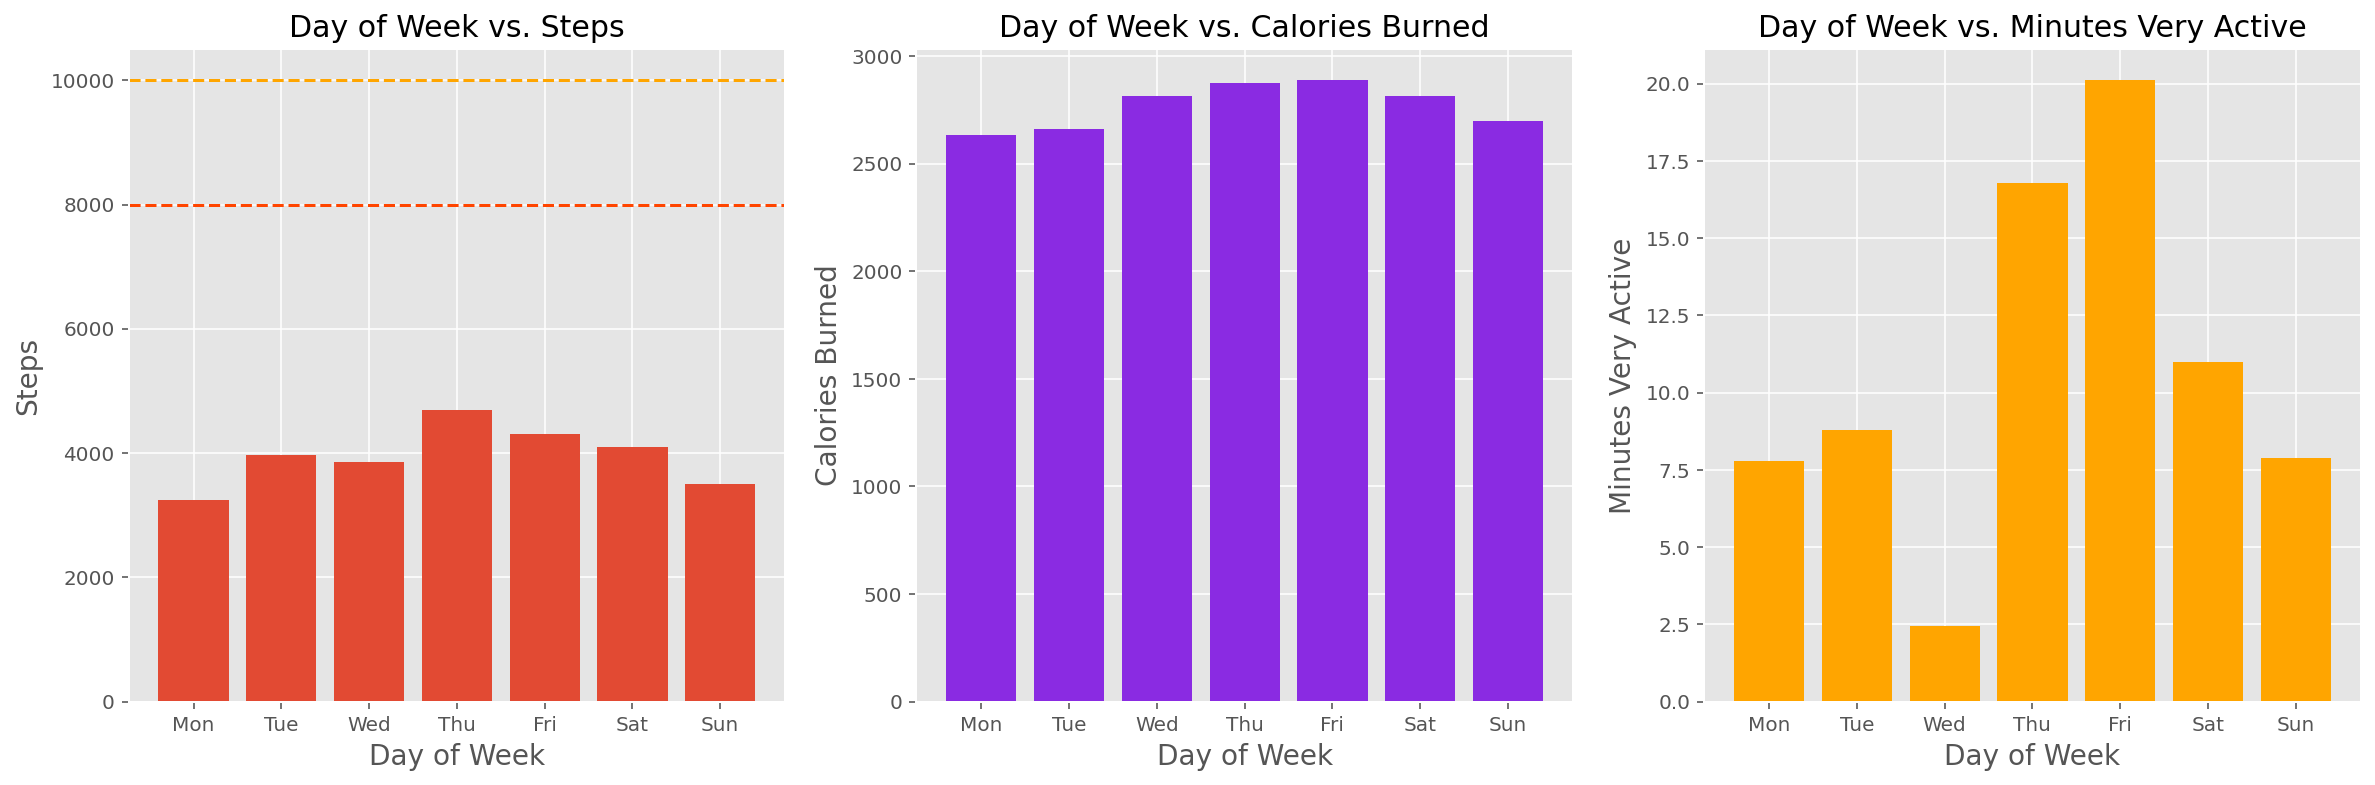

In [35]:
fig = plt.figure(figsize = (20,6))

ax = plt.subplot(131)  
plt.bar(dayGroupedData.index, dayGroupedData['Steps'])
plt.title('Day of Week vs. Steps', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Steps', fontsize=14)
ax.axhline(8000, color="orangered", linestyle='--')
ax.axhline(10000, color="orange", linestyle='--')
ax.set_xticklabels(minDayCodes)

#############

ax2 = fig.add_subplot(132)
plt.bar(dayGroupedData.index, dayGroupedData['Calories Burned'], color='blueviolet')
plt.title('Day of Week vs. Calories Burned', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Calories Burned', fontsize=14)
ax2.set_xticklabels(minDayCodes)

#############

ax3 = fig.add_subplot(133)
ax3.set_xticklabels(minDayCodes)
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Very Active'], color='orange')
plt.title('Day of Week vs. Minutes Very Active', fontsize=15)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Minutes Very Active', fontsize=14)
plt.show()

Text(0.5, 1.0, '"Sedentary minutes" per day')

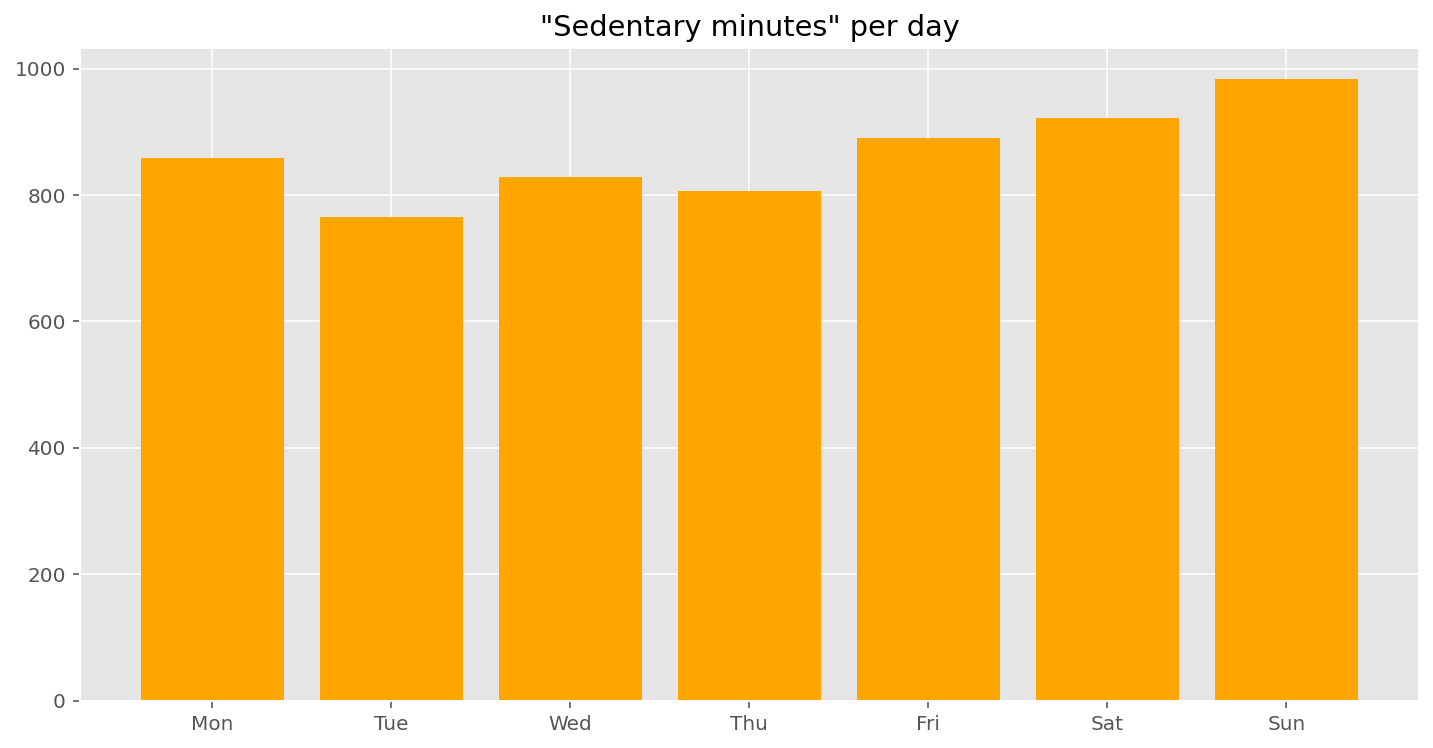

In [36]:
plt.bar(dayGroupedData.index, dayGroupedData['Minutes Sedentary'], color='orange', tick_label=minDayCodes[1:])
plt.title('"Sedentary minutes" per day')


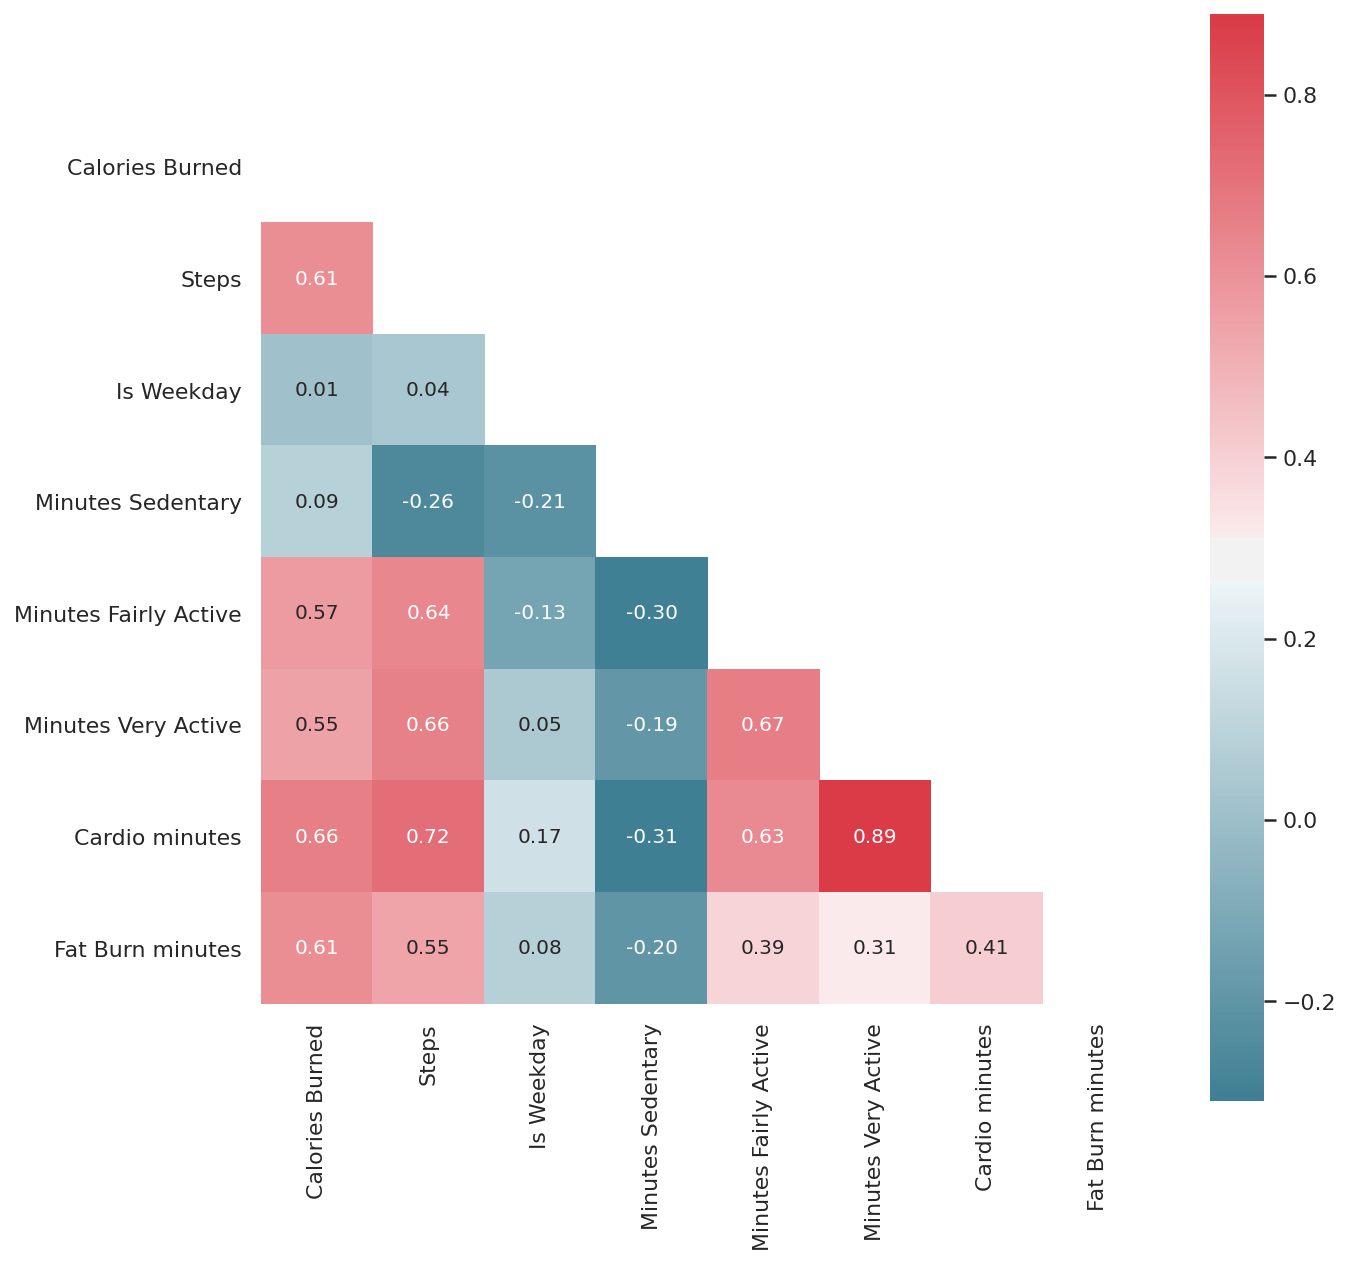

In [37]:
correlationOf = 'Calories Burned'
corrdf_calories = data[['Calories Burned','Steps', 'Is Weekday', 'Minutes Sedentary', 'Minutes Fairly Active', 'Minutes Very Active', 'Cardio minutes', 'Fat Burn minutes']]
plot_heatmap(corrdf_calories.corr(), correlationOf, '')

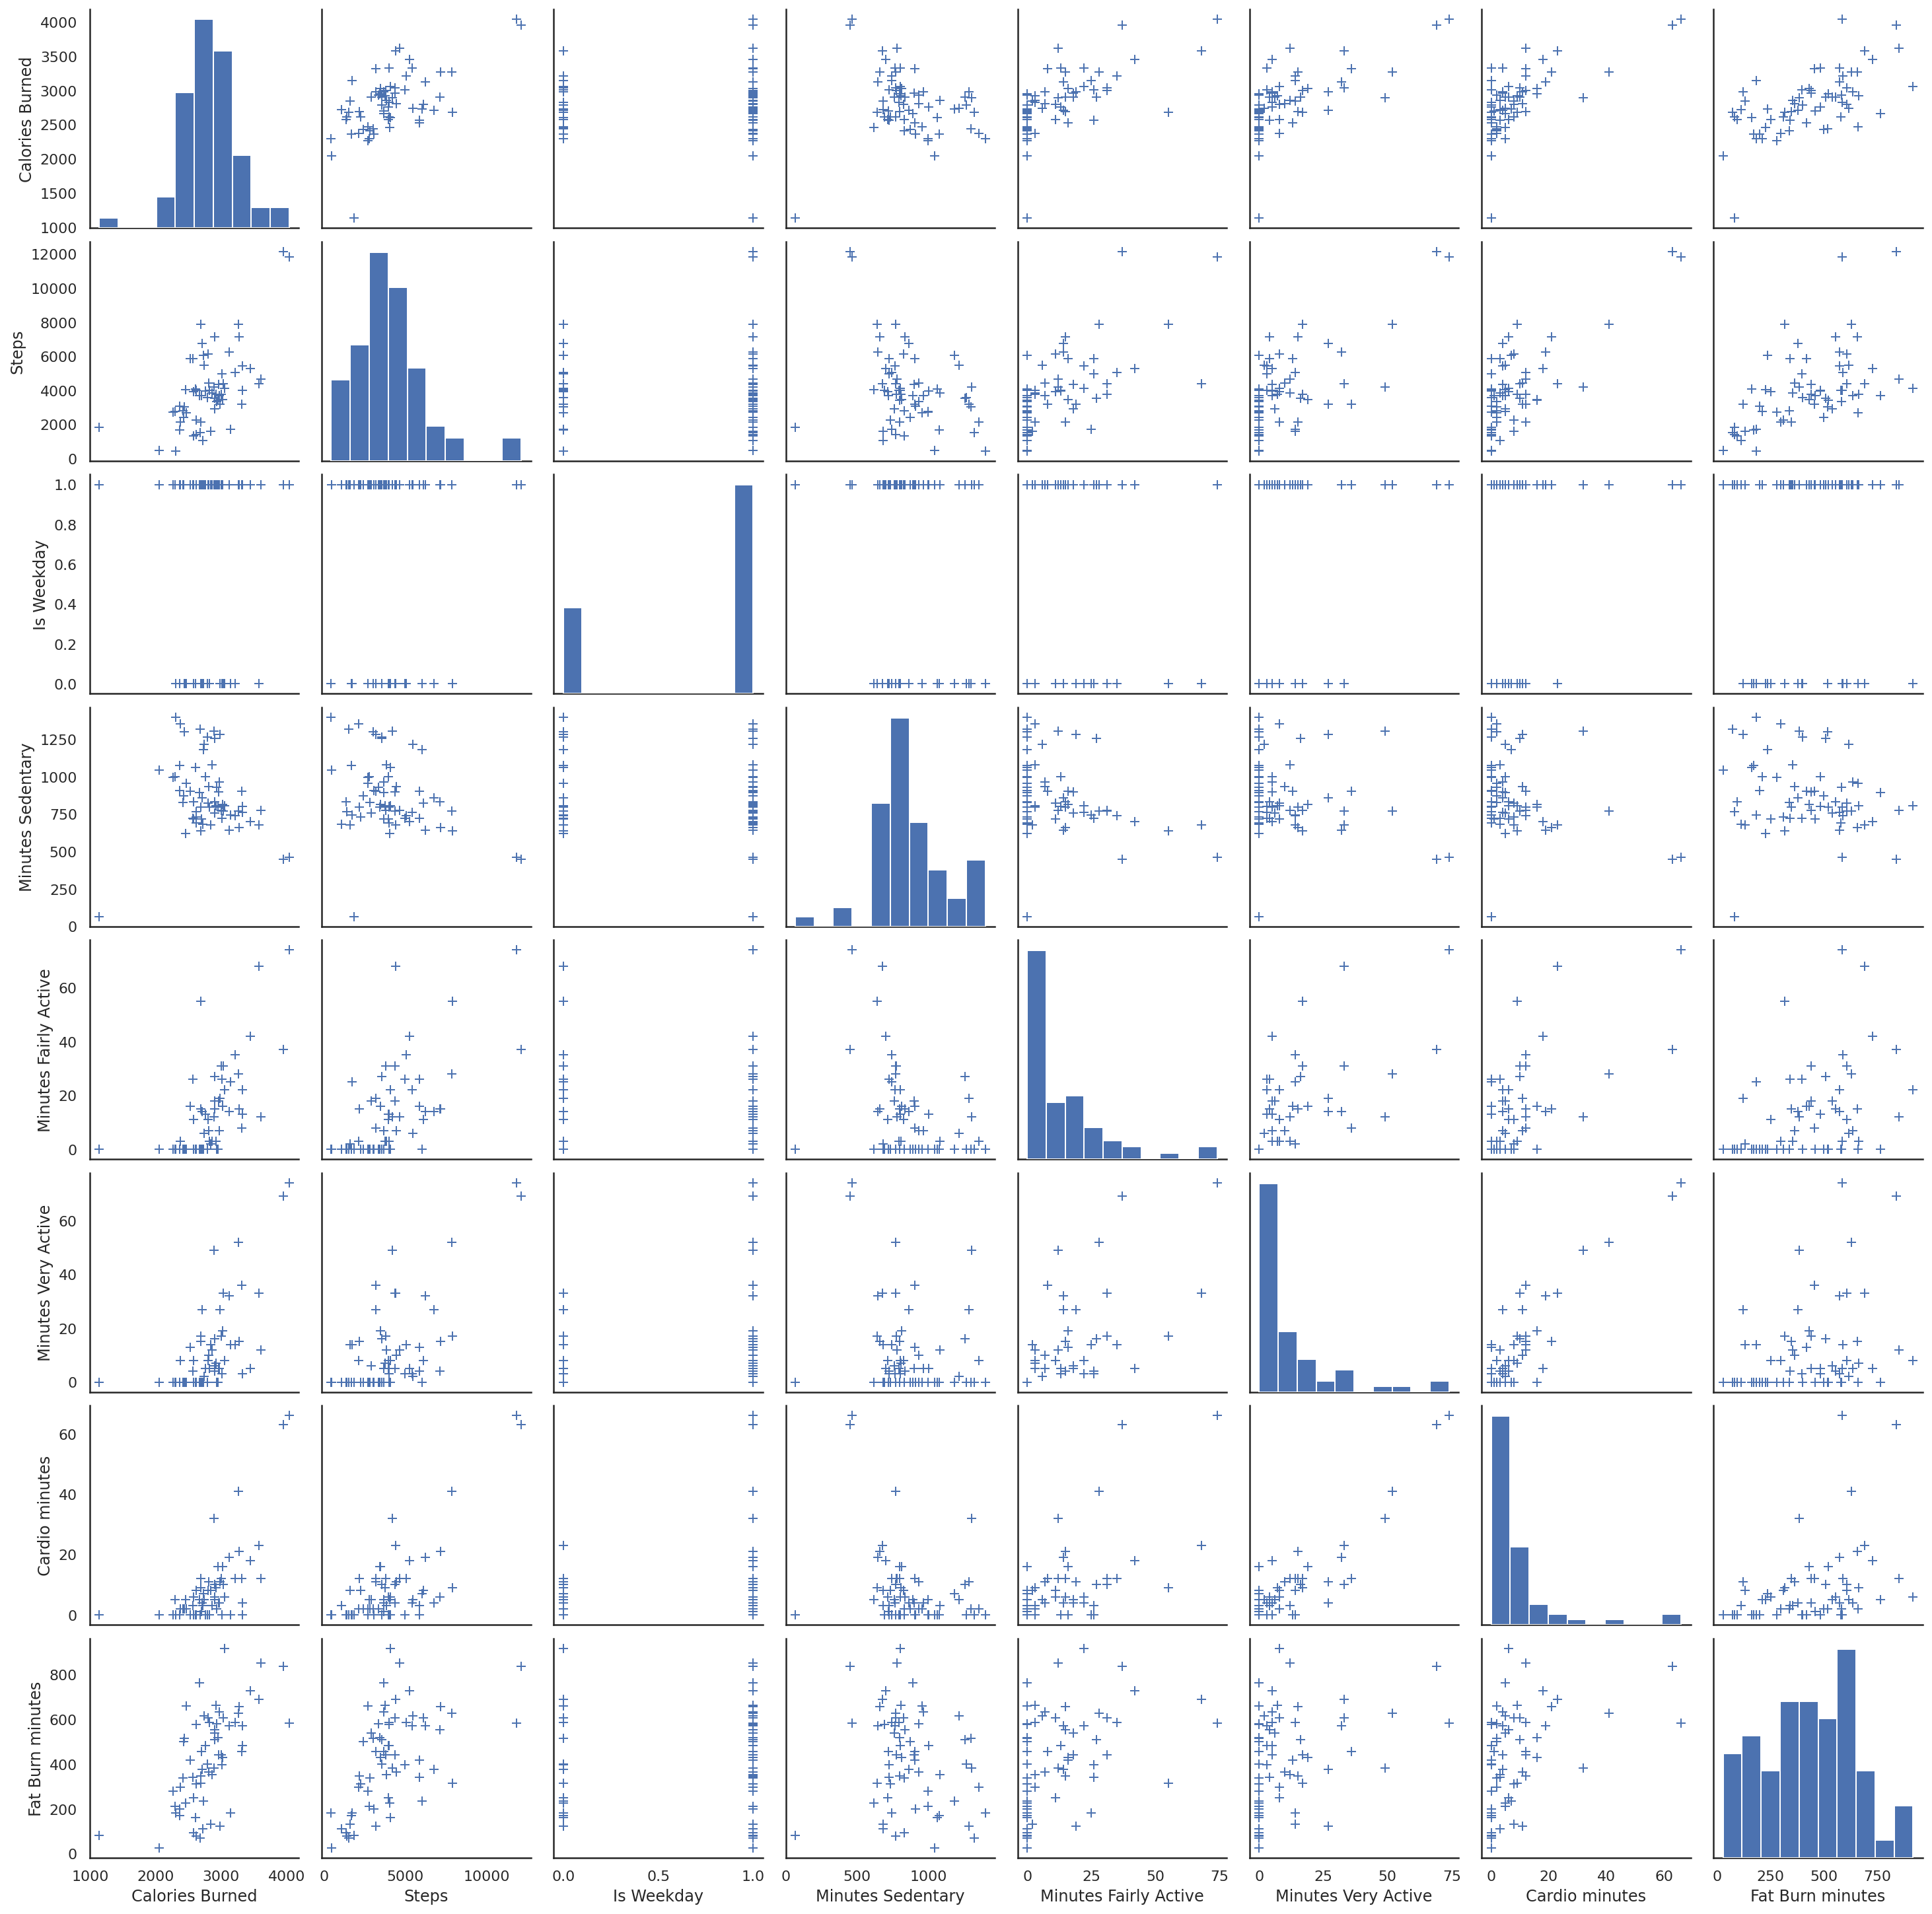

In [38]:
# Basic correlogram
sns.pairplot(corrdf_calories.dropna(), kind="scatter", markers="+", plot_kws=dict(s=50, edgecolor="b", linewidth=1))
plt.show()

In [39]:
data

,Active Score,Activity Calories,Calories BMR,Calories Burned,Cardio calories,Cardio minutes,Date,Day of Week,Distance (Km),Elevation (Ft),Fat Burn calories,Fat Burn minutes,Floors,Is Weekday,Is Weekend,Minutes Fairly Active,Minutes Lightly Active,Minutes Sedentary,Minutes Very Active,Normal Cardio calories,Normal Cardio minutes,Peak calories,Peak minutes,Resting Heart Rate,Steps,% Deep sleep,% Light sleep,% REM sleep,Deep sleep count,Light sleep count,Minutes Asleep,Minutes Awake,Minutes Awake count,Minutes Deep sleep,Minutes Light sleep,Minutes REM sleep,Minutes to fall asleep,REM sleep count,Sleep Efficiency,Sleep End time,Sleep Start time,Time in bed,Day Label,Active exercise,Sleep Bucket,Awake Bucket,% Awake,% Restorative sleep,Restorative sleep mins
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-04-11,-1,992,2263,3143,0.00000,0.0,2020-04-11,6,0.79,10,922.86249,181.0,1,0,1,25,115,742,14,1423.19826,755.0,0.0,0.0,62.0,1731,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sat,False,NaN,NaN,NaN,NaN,NaN
2020-04-12,-1,0,2208,2209,NaN,NaN,2020-04-12,7,0.00,0,NaN,NaN,0,0,1,0,0,1440,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sun,False,NaN,NaN,NaN,NaN,NaN
2020-04-13,-1,575,2168,2682,0.00000,0.0,2020-04-13,1,0.69,10,280.49328,71.0,1,1,0,0,121,1319,0,1397.34736,702.0,0.0,0.0,62.0,1511,11.0,63.0,14.0,5.0,49.0,556.0,90.0,48.0,67.0,402.0,87.0,0.0,11.0,92.0,2020-04-14T08:03:30.000,2020-04-13T21:17:30.000,646.0,Mon,False,21.5,8.5,12.0,25.0,154.0
2020-04-14,-1,592,2136,2723,43.31528,3.0,2020-04-14,2,0.49,20,442.79490,110.0,2,1,0,0,110,684,0,1845.94296,1066.0,0.0,0.0,62.0,1069,14.0,63.0,12.0,3.0,55.0,496.0,73.0,52.0,79.0,353.0,64.0,0.0,9.0,96.0,2020-04-15T07:08:00.000,2020-04-14T21:38:30.000,569.0,Tue,False,22.0,7.5,11.0,26.0,143.0
2020-04-15,-1,464,2110,2617,0.00000,0.0,2020-04-15,3,0.64,40,260.17950,80.0,4,1,0,0,103,768,0,2328.56988,1341.0,0.0,0.0,63.0,1410,17.0,51.0,23.0,3.0,32.0,439.0,49.0,34.0,82.0,245.0,112.0,0.0,12.0,96.0,2020-04-16T07:14:00.000,2020-04-15T23:05:30.000,488.0,Wed,False,23.5,7.5,9.0,40.0,194.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-12,-1,2585,1876,4041,621.83932,66.0,2020-06-12,5,5.38,130,2184.64715,583.0,13,1,0,74,287,464,74,1183.60573,764.0,0.0,0.0,73.0,11842,19.0,44.0,23.0,5.0,12.0,207.0,40.0,9.0,45.0,107.0,55.0,0.0,4.0,88.0,2020-06-13T05:09:00.000,2020-06-13T01:02:00.000,247.0,Fri,True,1.5,5.5,14.0,42.0,100.0
2020-06-13,-1,612,1876,2603,0.00000,0.0,2020-06-13,6,1.84,10,550.95068,162.0,1,0,1,0,130,1063,0,934.19239,607.0,0.0,0.0,75.0,4075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sat,False,NaN,NaN,NaN,NaN,NaN
2020-06-14,-1,1099,1876,2730,64.89438,7.0,2020-06-14,7,2.75,10,642.42830,234.0,1,0,1,0,259,1181,0,1225.69586,641.0,0.0,0.0,74.0,6042,16.0,49.0,24.0,4.0,42.0,468.0,70.0,42.0,83.0,259.0,126.0,0.0,12.0,92.0,2020-06-15T07:54:30.000,2020-06-14T22:56:30.000,538.0,Sun,False,23.0,8.0,11.0,40.0,209.0


(array([737530., 737537., 737546., 737553., 737560., 737567., 737577.,
        737584., 737591.]), <a list of 9 Text major ticklabel objects>)

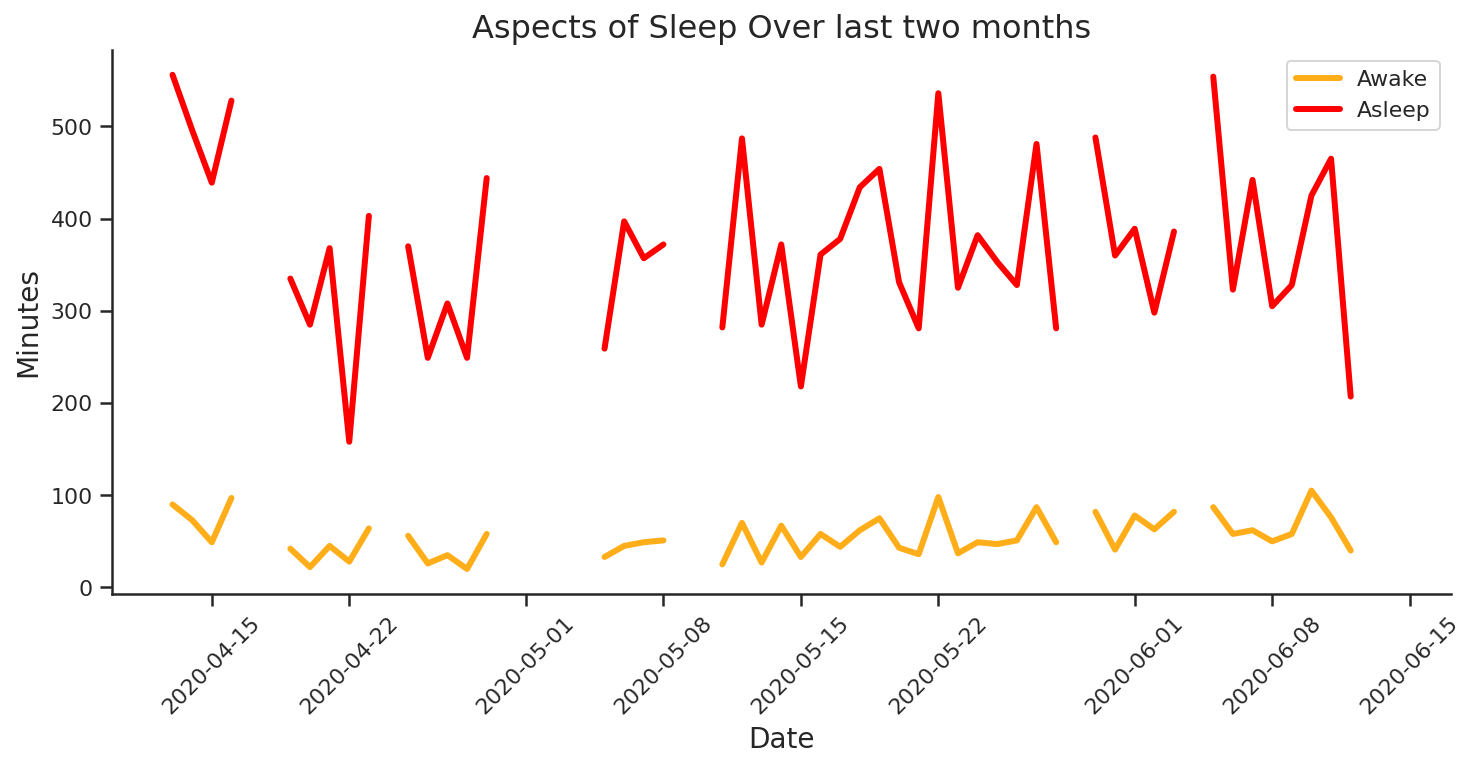

In [54]:
fig = plt.figure(figsize = (12,5))
plt.plot(data['Date'],data['Minutes Awake'], linestyle='-', 
         markersize=10, color='orange', label='Awake', linewidth=3.0, alpha=0.9)
plt.plot(data['Date'],data['Minutes Asleep'], linestyle='-', 
         markersize=10, color='red', label='Asleep', linewidth=3.0)

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()

plt.xlabel('Date', fontsize=14)
plt.ylabel('Minutes', fontsize=14)
plt.title('Aspects of Sleep Over last two months', fontsize=16)
plt.legend()
plt.xticks(rotation=45)

,count,mean,std,min,25%,50%,75%,max
Time in bed,54.0,7.067901,1.838357,3.1,5.941667,7.008333,8.341667,10.766667


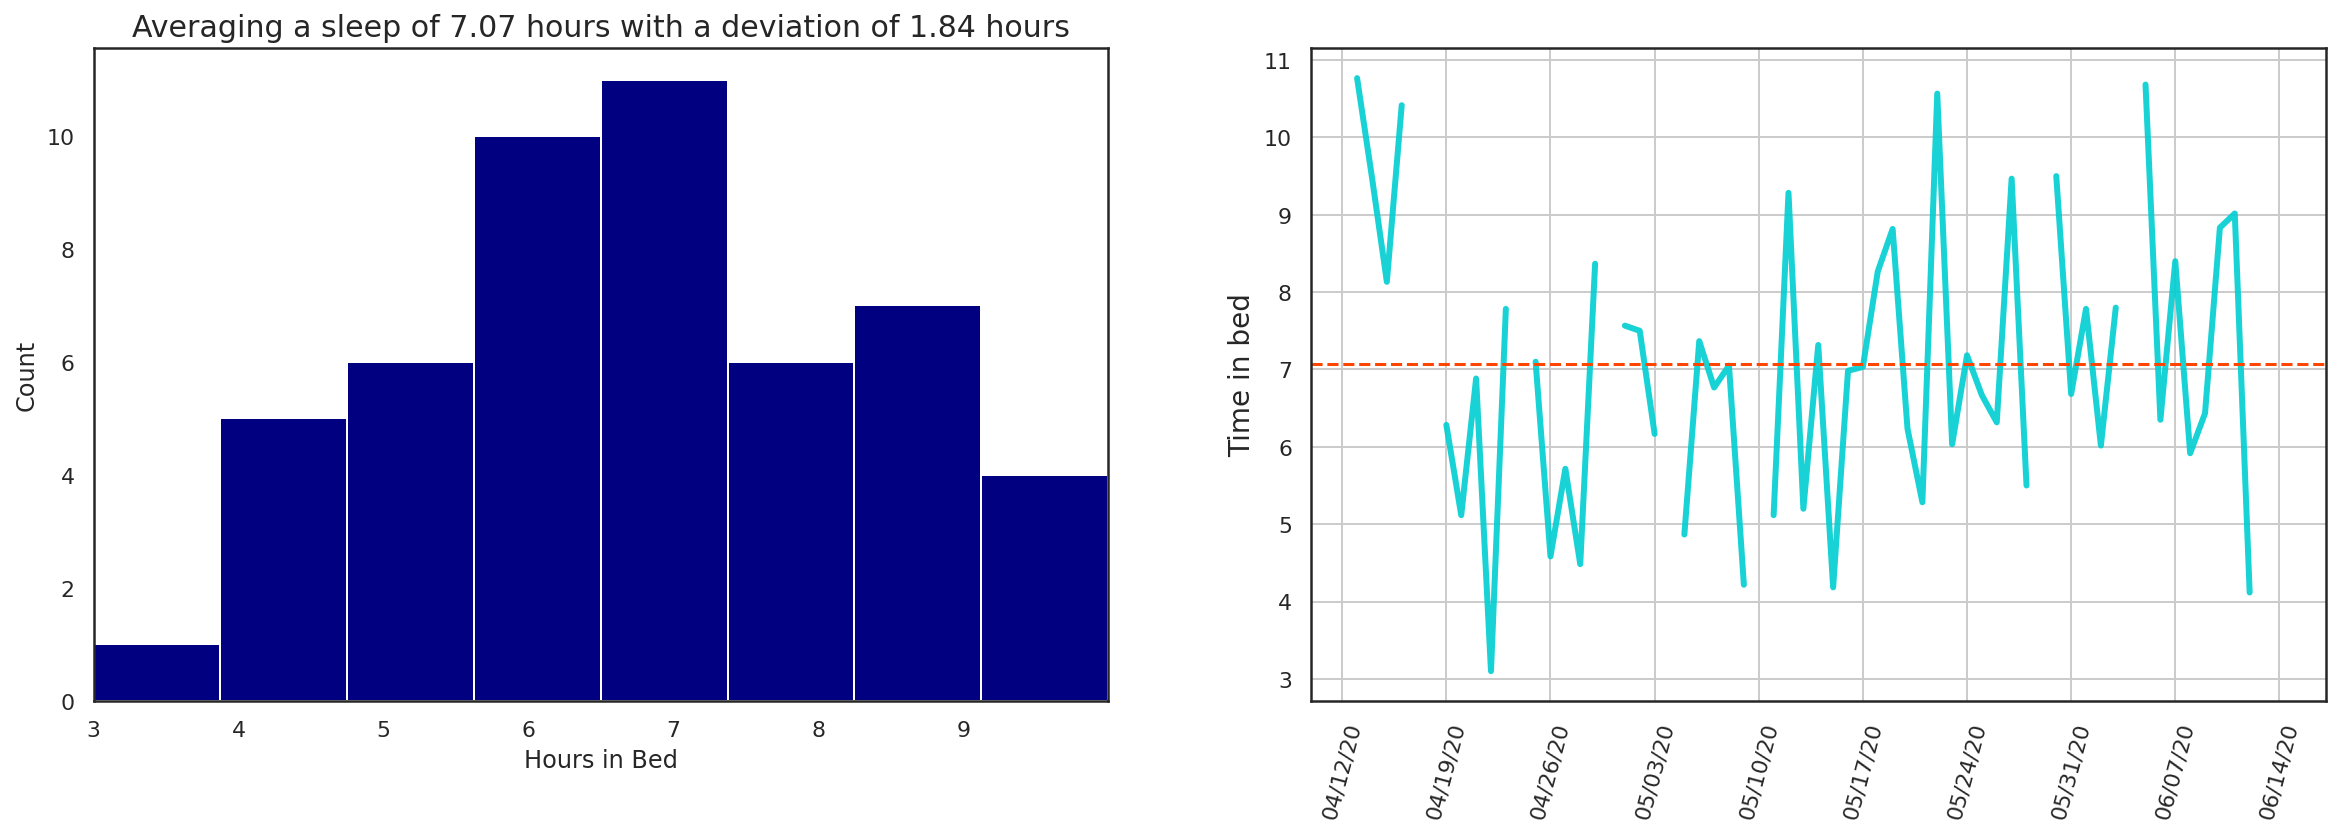

In [55]:
import matplotlib.dates as mdates

sleepDesc = pd.DataFrame(data['Time in bed']/60).describe().transpose()
avgSleepHours = round(sleepDesc.at['Time in bed','mean'],2)
summary = 'Averaging a sleep of {} hours with a deviation of {} hours'.format(avgSleepHours, round(sleepDesc.at['Time in bed','std'],2))
hoursInBed = data['Time in bed']/60

fig = plt.figure(figsize = (20,6))

ax = plt.subplot(121)  
plt.hist(hoursInBed, bins = 8, range = (3, 10), color="navy")
plt.xlim(3, 10)
plt.xticks(range(3, 10))
plt.xlabel('Hours in Bed')
plt.ylabel('Count');
plt.title(summary, fontsize=15)

#############

ax2 = fig.add_subplot(122)
plt.plot(data['Date'],hoursInBed, linestyle='-', 
         markersize=10, color='darkturquoise', label='% Light', linewidth=3.0, alpha=0.9)
plt.ylabel('Time in bed', fontsize=14)
ax2.axhline(avgSleepHours, color="orangered", linestyle='--')
ax2.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=6))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%D'))
ax2.grid(True)
plt.xticks(rotation=75)
plt.plot()

sleepDesc

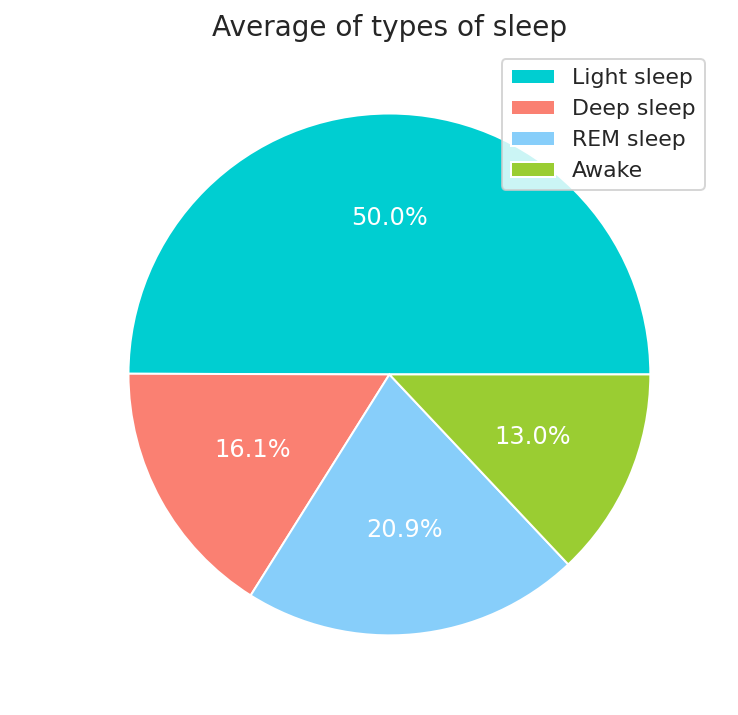

In [56]:
avgSleep = data[['Minutes Light sleep', 'Minutes Deep sleep', 'Minutes REM sleep', 'Minutes Awake']].mean()

fig = plt.figure(figsize = (6,6))
labels=['Light sleep', 'Deep sleep', 'REM sleep', 'Awake']
plt.pie(avgSleep, colors = ['darkturquoise', 'salmon', 'lightskyblue', 'yellowgreen'], autopct='%1.1f%%', labels=labels, textprops=dict(color="w"))

# #carve the donut
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# p=plt.gcf()
# p.gca().add_artist(my_circle)

plt.title('Average of types of sleep', fontsize=14)
plt.legend()
plt.show()

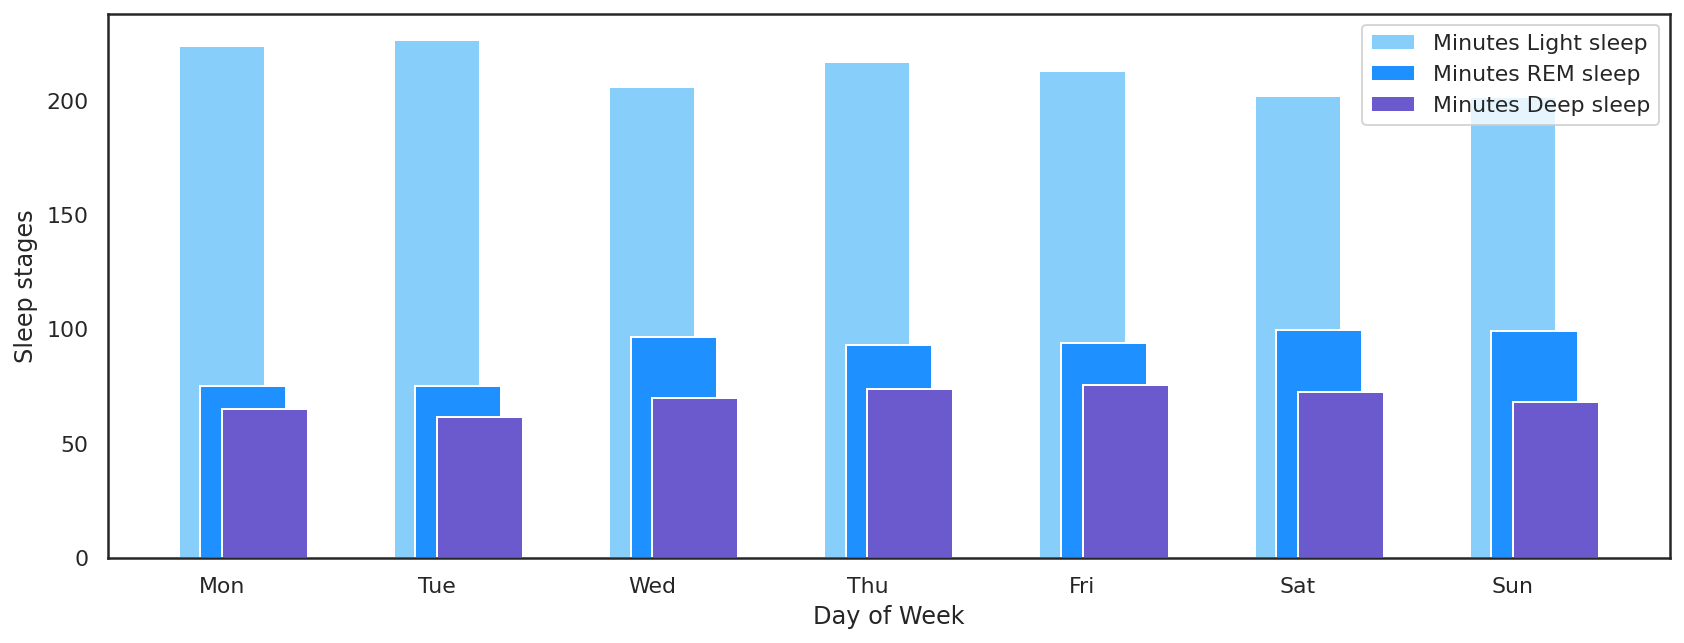

In [57]:


fig = plt.figure(figsize = (14,5))
plt.bar((dayGroupedData.index), dayGroupedData['Minutes Light sleep'],width = 0.4, color='lightskyblue', label="Minutes Light sleep", tick_label=minDayCodes[1:])
plt.bar((dayGroupedData.index + 0.1), dayGroupedData['Minutes REM sleep'], width = 0.4, color='dodgerblue', label="Minutes REM sleep")
plt.bar((dayGroupedData.index + 0.2), dayGroupedData['Minutes Deep sleep'], width = 0.4, color='slateblue', label="Minutes Deep sleep")
plt.xlabel('Day of Week')
plt.ylabel('Sleep stages')
plt.legend()



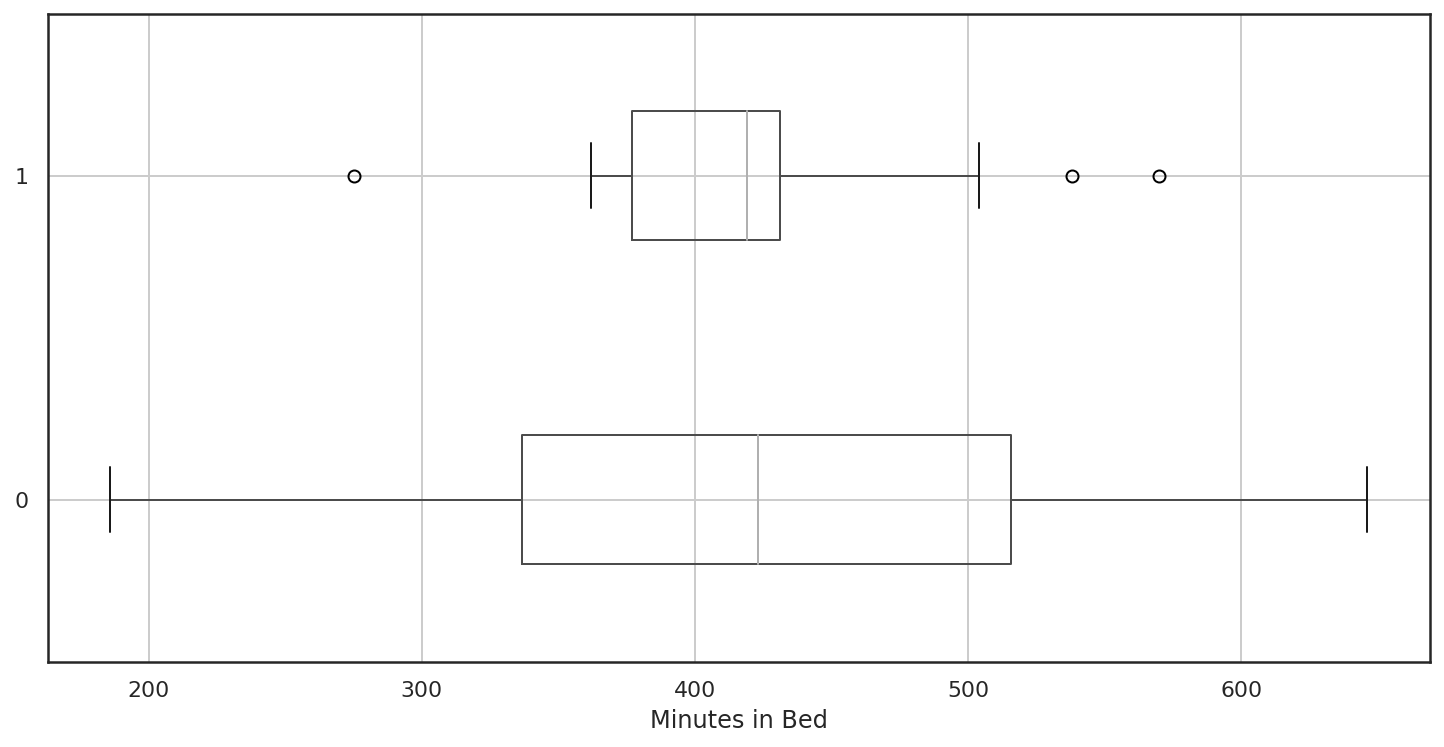

In [58]:
ax = sleepData.boxplot(column = 'Time in bed', by = 'Is Weekend', vert = False, widths = 0.4)
plt.xlabel('Minutes in Bed')
plt.suptitle('')
plt.title('');

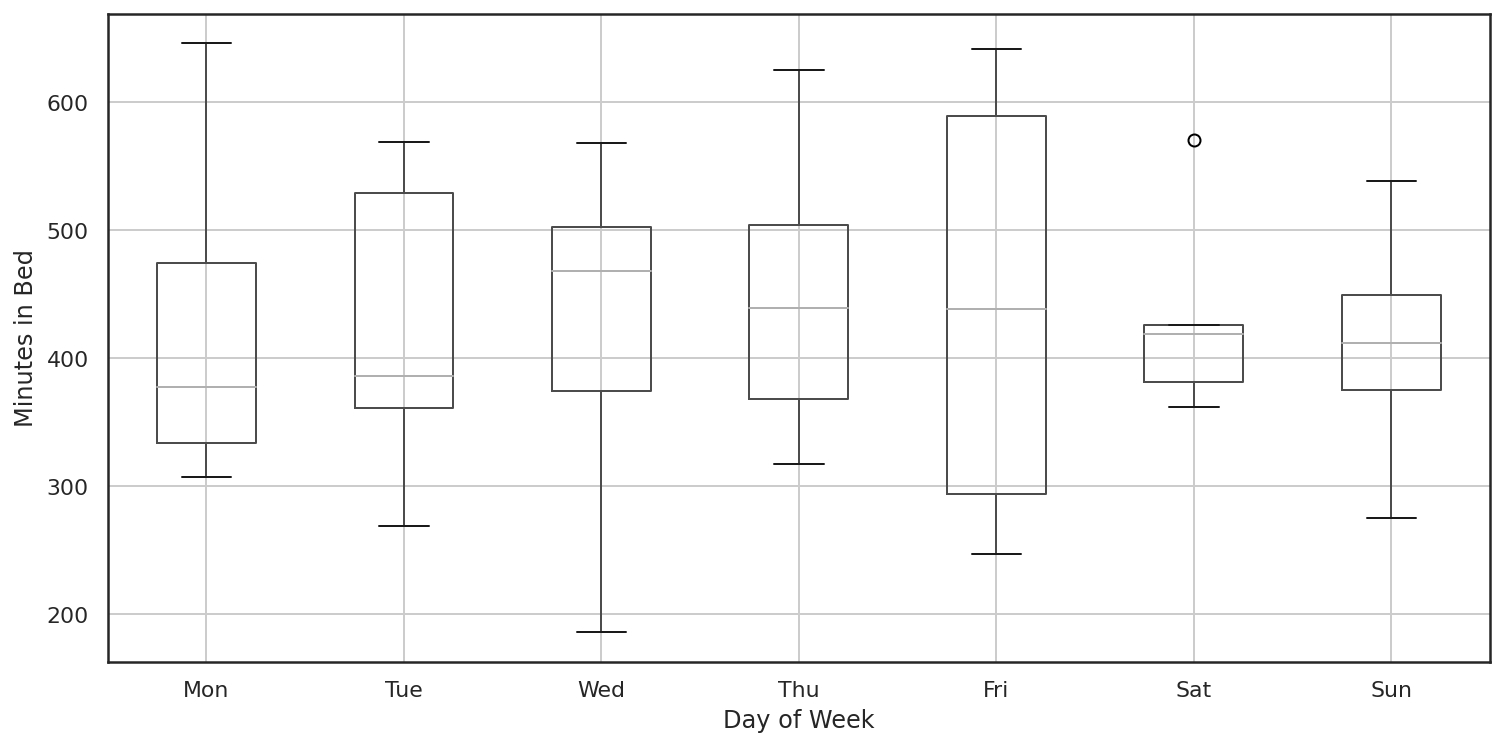

In [59]:
ax = sleepData.boxplot(column = 'Time in bed', by = 'Day of Week')
ax.set_xticklabels(minDayCodes[1:])
plt.ylabel('Minutes in Bed')
plt.suptitle('')
plt.title('');